In [1]:
import pandas as pd
import json_handling as jh
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
folder_path = 'aob_2025/orders'

all_data = jh.load_json_objects_from_folder(folder_path)
print(f"Loaded {len(all_data)} JSON objects from {folder_path}")

dfs = jh.extract_dataframes(all_data)
    

Loaded 43800 JSON objects from aob_2025/orders


In [3]:
df_orders = dfs['orders']
df_payment_details = dfs['payment_details']
df_orderlines = dfs['orderlines']
df_shown_addons = dfs['shown_addons']
df_search_data = dfs['search_data']
df_search_orders = dfs['search_orders']
df_search_parameters = dfs['search_parameters']


In [21]:
df_search_orders

,parent_order_id,search_order_key,order_id,order_type,user_ipaddress,paid,paid_at,paid_at_date,paid_transact,cancelled,...,booking_type,type,timestamp,logreader_type,orderlines,shown_addons,variants,pr,pr_type,segtypes
0,1951660,1,1951660,air,91.32.25.144,True,1735306785,2024-12-27T14:39:45+01:00,smNO7I2VWhoYUV/tMTLNYK5hKdM=,False,...,"{'ndc': 1, 'lcc': 1, 'reg': 0}",order,1735306509,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'KK': 15, 'AVB': 84, 'SMS': 3, 'VIP': 24, 'NO...",{'AVB First test_control': ''},336960.0,metas,NaN
1,1951669,1,1951668,air,194.230.144.96,False,0,None,None,False,...,"{'ndc': 0, 'lcc': 0, 'reg': 1}",order,1735307371,order,"{'air': {'product_code': 'air', 'orderline_typ...",None,None,336510.0,metas,NaN
2,1951669,2,1951669,air,194.230.144.96,False,0,None,None,False,...,"{'ndc': 0, 'lcc': 0, 'reg': 1}",order,1735307422,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'KK': 20, 'AVB': 58, 'SMS': 5, 'VIP': 22, 'BA...",{},336510.0,metas,NaN
3,1951678,1,1951678,air,193.90.162.48,False,0,None,None,False,...,"{'ndc': 0, 'lcc': 0, 'reg': 1}",order,1735308049,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'KK': 195, 'AVB': 275, 'SMS': 49, 'VIP': 125,...",{},336895.0,metas,NaN
4,1951692,1,1951692,air,213.244.61.133,True,1735310255,2024-12-27T15:37:35+01:00,1951692-1009092-6918ca,False,...,"{'ndc': 0, 'lcc': 0, 'reg': 1}",order,1735309837,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'KK': 10, 'AVB': 26, 'SMS': 5, 'VIP': 11, 'NO...",{},331462.0,metas,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50665,1919294,1,1919294,air,109.43.115.161,True,1731698587,2024-11-15T20:23:07+01:00,uNnY6VLOtLqmBZraYcB4rka8fCc=,False,...,NaN,order,1731698279,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'SMS': 5, 'CHECKIN': 8, 'CHANGE': 40, 'NONE':...",NaN,334816.0,flights,NaN
50666,1919343,1,1919343,air,155.4.129.13,True,1731703468,2024-11-15T21:44:28+01:00,3364a2_1919343,False,...,NaN,order,1731703380,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'SMS': 49, 'CHECKIN': 79, 'AVB': 295, 'VIP': ...",NaN,336673.0,metas,NaN
50667,1919346,1,1919346,air,46.114.194.156,True,1731704130,2024-11-15T21:55:30+01:00,1919346-980243-13a109,False,...,NaN,order,1731703956,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'SMS': 5, 'CHECKIN': 16, 'NONE': 0, 'VIP': 40...",NaN,331462.0,metas,NaN
50668,1919347,1,1919347,air,217.122.22.162,True,1731704134,2024-11-15T21:55:34+01:00,dc7ac6_1919347,False,...,NaN,order,1731704010,order,"{'air': {'product_code': 'air', 'orderline_typ...","{'CHECKIN': 3, 'SMS': 3, 'VIP': 12, 'BASIC': 0...",NaN,335579.0,metas,NaN


In [4]:

# Merge orders with payment details
df_combined = df_orders.merge(
    df_payment_details[['order_id', 'cost', 'total_sales_price', 'paid_amount']],
    on='order_id',
    how='left',
    suffixes=('', '_payment')
)

# Merge with search data
df_combined = df_combined.merge(
    df_search_data,
    left_on='order_id',
    right_on='parent_order_id',
    how='left',
    suffixes=('', '_search')
)

# Merge with shown addons if present
if 'df_shown_addons' in locals():
    df_combined = df_combined.merge(
        df_shown_addons,
        on='order_id',
        how='left'
    )

# Convert mobile to boolean
if 'mobile' in df_combined.columns:
    df_combined['mobile'] = df_combined['mobile'].astype(bool)

# Calculate number of legs from itinerary_string
def count_itinerary_legs(itinerary):
    if pd.isna(itinerary) or itinerary == '':
        return 0
    
    if isinstance(itinerary, str):
        if ',' in itinerary:
            # Format: "FRA-LON, LON-AGP, AGP-FRA"
            return len(itinerary.split(','))
        elif '-' in itinerary:
            # Format: "FRA-LON-AGP-FRA"
            segments = itinerary.split('-')
            return len(segments) - 1 if len(segments) > 1 else 0
    
    return 0

if 'itinerary_string' in df_combined.columns:
    df_combined['num_legs'] = df_combined['itinerary_string'].apply(count_itinerary_legs)

# Process search parameters if available
if 'df_search_parameters' in locals():
    if 'rooms' in df_search_parameters.columns:
        df_search_parameters['num_rooms'] = df_search_parameters['rooms'].apply(
            lambda x: len(x) if isinstance(x, list) else 0
        )
    else:
        df_search_parameters['num_rooms'] = 0
    
    df_search_parameters['adults'] = pd.to_numeric(
        df_search_parameters.get('adults', 0), errors='coerce'
    ).fillna(0)
    
    df_search_parameters['children'] = pd.to_numeric(
        df_search_parameters.get('children', 0), errors='coerce'
    ).fillna(0)
    
    param_cols = ['parent_order_id']
    if 'num_rooms' in df_search_parameters.columns:
        param_cols.append('num_rooms')
    if 'adults' in df_search_parameters.columns:
        param_cols.append('adults')
    if 'children' in df_search_parameters.columns:
        param_cols.append('children')
    if 'leg_0_origin_continent' in df_search_parameters.columns:
        param_cols.append('leg_0_origin_continent')
    if 'leg_0_destination_continent' in df_search_parameters.columns:
        param_cols.append('leg_0_destination_continent')
    
    if len(param_cols) > 1:
        df_combined = df_combined.merge(
            df_search_parameters[param_cols],
            left_on='order_id',
            right_on='parent_order_id',
            how='left',
            suffixes=('', '_params')
        )

# Process orderlines to create columns for each product code
# First, prepare the orderlines data
df_orderlines_numeric = df_orderlines.copy()
for col in ['qty', 'profit', 'price', 'cost']:
    if col in df_orderlines_numeric.columns:
        df_orderlines_numeric[col] = pd.to_numeric(df_orderlines_numeric[col], errors='coerce')

# Function to categorize seat product codes
def categorize_seat(product_code):
    if not isinstance(product_code, str):
        return product_code
    
    if product_code.startswith('seat_'):
        seat_num = product_code.split('_')[1]
        try:
            seat_num = int(seat_num)
            if 1 <= seat_num <= 15:
                return 'seat_1_15'
            elif 16 <= seat_num <= 25:
                return 'seat_16_25'
            else:  # 26+
                return 'seat_26plus'
        except ValueError:
            return product_code
    return product_code

# Apply the categorization
df_orderlines_numeric[df_orderlines_numeric['product_code'] == 'SEAT2'] = 'seat_2'
df_orderlines_numeric['product_code_category'] = df_orderlines_numeric['product_code'].apply(categorize_seat)

# Create a pivot table for quantities by product code
product_pivot = df_orderlines_numeric.pivot_table(
    index='order_id',
    columns='product_code_category',
    values='qty',
    aggfunc='sum',
    fill_value=0
)

# Reset index to make order_id a regular column
product_pivot = product_pivot.reset_index()

# Merge the pivot table with the combined data
df_combined = df_combined.merge(
    product_pivot,
    on='order_id',
    how='left'
)

# Fill missing values
df_combined.fillna(0, inplace=True)

# Remove any duplicate parent_order_id columns
if 'parent_order_id_params' in df_combined.columns:
    df_combined.drop('parent_order_id_params', axis=1, inplace=True)

/var/folders/gq/50zq6n4d3vl2rcjc5w22qs5w0000gn/T/ipykernel_34094/3855120179.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'seat_2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_orderlines_numeric[df_orderlines_numeric['product_code'] == 'SEAT2'] = 'seat_2'
/var/folders/gq/50zq6n4d3vl2rcjc5w22qs5w0000gn/T/ipykernel_34094/3855120179.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'seat_2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_orderlines_numeric[df_orderlines_numeric['product_code'] == 'SEAT2'] = 'seat_2'
/var/folders/gq/50zq6n4d3vl2rcjc5w22qs5w0000gn/T/ipykernel_34094/3855120179.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 

In [6]:
columns_to_remove = [
    "search_id", "user_ipaddress", "paid_transact", "paid_at_date", "order_type",
    "paid_unique_id", "searchrule_action_id", "type", "timestamp", "timestamp_date", "logreader_type", 
    "search_id_search", "gate_id_search", "status", "search_from_ip", "search_type", "process_status", 
    "created_at_search", "created_at_date_search", "itinerary_string", "type_search", "timestamp_search", 
    "timestamp_date_search", "logreader_type_search", "searchrule_id", "searchrule_version_id", 
    "flight_rule_version_id", "hotel_rule_version_id", "meta_rule_version_id", "ancillary_rule_version_id", 
    "presentation_rule_version_id", "text_rule_version_id", "experiments", "parent_order_id", "paid_at", "cancelled_at", "cancelled_description", "block", "search_rule_version_id",
    "gate_id", "created_at", "created_at_date", "midoffice_id", "meta_search", "resultsms"
]

df_cleaned = df_combined.drop(columns=columns_to_remove, errors='ignore')

df = df_cleaned[df_cleaned['paid'] == True]
df = df.drop(columns=['order_id', 'payment_fee', 'paid'])



In [7]:
df_cleaned.to_csv('orders_cleaned.csv')

In [10]:
numeric_features = [
    'segment_commission',
    'cost',
    'total_sales_price',
    'paid_amount',
    'meta_clicks',
    'tot_pax',
    'num_legs',
    'num_rooms',
    'adults',
    'children',
    'AVB',
    'BAGFO',
    'BIKE',
    'CHANGE',
    'CHECKIN',
    'FLEX',
    'FORSNY',
    'GARANTI',
    'GOLFBAG',
    'KK',
    'RESESKYDD',
    'SKI',
    'SMS',
    'VIP',
    'VIPPREM1',
    'addon',
    'air',
    'baggage',
    'carryon',
    'climate',
    'discount',
    'fee',
    'seat_16_25',
    'seat_1_15',
    'seat_26plus',
    'upgrade',
]
categorical_features = [
    'cancelled',
    'mobile',
    'leg_0_origin_continent',
    'leg_0_destination_continent',
]

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=20)),
        ('kmeans', KMeans(n_clusters=23, random_state=42))
    ]
)

pipeline.fit(df)
df['cluster'] = pipeline.predict(df)

print(df.head())


   cancelled  segment_commission      cost  total_sales_price  paid_amount  \
0      False               -1.26   1123.52               1186       1186.0   
3      False               12.80    266.92                260        260.0   
4      False              192.00   2510.00               2370       2370.0   
5      False              540.00  22500.00              22963      22963.0   
6      False              105.60  13017.00              13692      13692.0   

       gate_name country  meta_clicks  mobile  tot_pax  ...  baggage  carryon  \
0  DE_Skyscanner      DE            1   False      3.0  ...      0.0      0.0   
3   DE-Momondo-1      DE            2   False      1.0  ...      0.0      0.0   
4            n_m      NO            1    True      1.0  ...      0.0      0.0   
5   Flygresor-fc      SE            0   False      3.0  ...      0.0      0.0   
6            AOB      SE            0   False      2.0  ...      2.0      0.0   

   climate  discount  fee seat_16_25 seat_1_

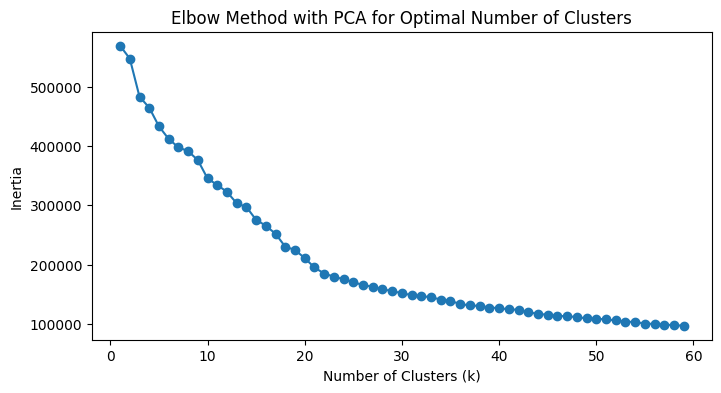

In [14]:
X_transformed = preprocessor.fit_transform(df)

pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_transformed)

inertia = []
k_range = range(1, 60)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method with PCA for Optimal Number of Clusters')
plt.show()

In [35]:
features = df.columns.to_list()
cluster_labels = df.columns.to_frame()

In [15]:
explained_variance = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance)

print("Explained Variance Ratio per Component:")
print(explained_variance)

print("\nCumulative Explained Variance:")
print(cumulative_variance)

Explained Variance Ratio per Component:
[0.14300844 0.05936607 0.0473467  0.04528462 0.04069616 0.03447337
 0.03294338 0.03273712 0.03085181 0.03019655 0.03005804 0.02988652
 0.02983817 0.02952775 0.02924268 0.02838892 0.02756987 0.02677841
 0.0263331  0.02572957]

Cumulative Explained Variance:
[0.14300844 0.20237451 0.24972121 0.29500582 0.33570198 0.37017536
 0.40311874 0.43585586 0.46670767 0.49690422 0.52696226 0.55684878
 0.58668695 0.6162147  0.64545737 0.67384629 0.70141616 0.72819457
 0.75452767 0.78025724]


In [46]:
df.to_excel('clusters.xlsx')

In [17]:
df['profit'] = df['total_sales_price'] - df['cost']

cluster_counts = df['cluster'].value_counts().to_frame()
cluster_avg_profit = df['profit'].groupby(df['cluster']).mean().to_frame(name='average profit')
cluster_avg_adults = df['adults'].groupby(df['cluster']).mean().to_frame(name='average adults')
cluster_avg_children = df['children'].groupby(df['cluster']).mean().to_frame(name='average children')
cluster_avg_vip_qty = df['VIP'].groupby(df['cluster']).mean().to_frame(name='average vip qty')
cluster_avg_bag_qty = df['baggage'].groupby(df['cluster']).mean().to_frame(name='average baggage qty')
cluster_avg_seat_1_15_qty = df['seat_1_15'].groupby(df['cluster']).mean().to_frame(name='average seat_1_15 qty')
cluster_avg_seat_16_25_qty = df['seat_16_25'].groupby(df['cluster']).mean().to_frame(name='average seat_16_25 qty')
cluster_avg_seat_26plus_qty = df['seat_26plus'].groupby(df['cluster']).mean().to_frame(name='average seat_26plus qty')
cluster_avg_num_legs = df['num_legs'].groupby(df['cluster']).mean().to_frame(name='average num legs')

cluster_stats = pd.concat([cluster_counts, cluster_avg_profit, cluster_avg_adults, cluster_avg_children, cluster_avg_vip_qty, cluster_avg_bag_qty, cluster_avg_seat_1_15_qty, cluster_avg_seat_16_25_qty, cluster_avg_seat_26plus_qty, cluster_avg_num_legs], axis=1)

In [18]:
cluster_stats.to_excel('cluster_stats.xlsx')